# SAD

In [ ]:
%cd drive/MyDrive/cs231a

/content/drive/MyDrive/cs231a


In [ ]:
#@title
!mkdir /content/000201
!unzip 000201.zip -d /content/000201

Streaming output truncated to the last 5000 lines.
  inflating: /content/000201/000201/cam09/1618798540100.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798540100.jpg  
  inflating: /content/000201/000201/cam09/1618798862099.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798862099.jpg  
  inflating: /content/000201/000201/cam09/1618798724600.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798724600.jpg  
  inflating: /content/000201/000201/cam09/1618798901099.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798901099.jpg  
  inflating: /content/000201/000201/cam09/1618798624600.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798624600.jpg  
  inflating: /content/000201/000201/cam09/1618798805599.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798805599.jpg  
  inflating: /content/000201/000201/cam09/1618798493600.jpg  
  inflating: /content/000201/__MACOSX/000201/cam09/._1618798493600.jpg  
  in

In [ ]:
!mv /content/000201 .

In [ ]:
!ls

/content/drive/MyDrive/cs231a


In [ ]:
#@title
%%writefile Scene.py
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

class Scene():
    def __init__(self, data_dir, scene_id):
        self.scene_id = scene_id
        self.data_dir = os.path.join(data_dir, 'scenes', self.scene_id)
        self.metadata = json.loads(open(os.path.join(self.data_dir, f"{self.scene_id}.json")).read())

        self.weather = self.metadata["meta_info"]['weather']
        self.period = self.metadata["meta_info"]['period']
        self.image_size = self.metadata["meta_info"]['image_size']

        self.cams = list(self.metadata["calib"].keys())
        self.poses = np.array([self.metadata["frames"][i]['pose'] for i in range(len(self.metadata["frames"]))])
        self.frame_ids = np.array([int(self.metadata["frames"][i]['frame_id']) for i in range(len(self.metadata["frames"]))])


    def get_pose(self, frame_id):
        frame_idx = np.where(self.frame_ids == frame_id)[0][0]
        pose_vec = self.poses[frame_idx]
        pose = R.from_quat(pose_vec[:4]).as_matrix()
        pose = np.hstack((pose, np.zeros((3, 1))))
        pose[:3, 3] = pose_vec[4:]
        return pose


    def get_camera_pose(self, frame_id, cam_id):
        cam_pose = np.array(self.metadata["calib"][cam_id]["cam_to_velo"]) # 4x4
        return cam_pose


    def get_k(self, cam_id):
        return np.array(self.metadata["calib"][cam_id]["cam_intrinsic"]).reshape(3, 3)

    
    def get_lidar_frame(self, frame_id):
        lidar_file = os.path.join(self.data_dir, 'lidar_roof', f"{frame_id}.bin")
        lidar_points = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
        return lidar_points


    def get_cam_frame(self, frame_id, cam_id):
        cam_file = os.path.join(self.data_dir, cam_id, f"{frame_id}.jpg")
        cam_image = np.array(Image.open(cam_file))
        return cam_image


    def plot_lidar_frame(self, frame_id):
        lidar_points = self.get_lidar_frame(frame_id)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(lidar_points[:, 0], lidar_points[:, 1], lidar_points[:, 2], c=lidar_points[:, 3], cmap='gray')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.show()




if __name__ == "__main__":
    scene = Scene(scene_id='000027')
    # scene.plot_lidar_frame(frame_id=scene.frame_ids[0])
    scene.get_cam_frame(frame_id=scene.frame_ids[0], cam_id=scene.cams[0])

Writing Scene.py


In [ ]:
#@title
%%writefile sfm.py
import numpy as np
import pandas as pd
import cv2

from Scene import Scene

from mayavi import mlab

def viz_3d(pt_3d):
    X = pt_3d[0,:]
    Y = pt_3d[1,:]
    Z = pt_3d[2,:]

    mlab.points3d(
        X,   # x
        Y,   # y
        Z,   # z
        mode="point", # How to render each point {'point', 'sphere' , 'cube' }
        colormap='copper',  # 'bone', 'copper',
        line_width=10,
        scale_factor=1
    )
    mlab.axes(xlabel='x', ylabel='y', zlabel='z',ranges=(0,20,0,20,0,10),nb_labels=10)
    mlab.show()


scene = Scene(data_dir='/Users/alexvesel/Downloads/oncedataset', scene_id='000112')

# get pairs of frames and use normalized cross correlation to find corresponding points
def sfm(cam_idx):
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    flann = cv2.FlannBasedMatcher(dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1), dict(checks=50))

    cam_id = scene.cams[cam_idx]
    K = scene.get_k(cam_id=cam_id)

    R_t_0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
    R_t_1 = np.empty((3,4))
    P1 = np.matmul(K, R_t_0)
    P2 = np.empty((3,4))

    X = np.array([])
    Y = np.array([])
    Z = np.array([])

    for i, (frame_id1, frame_id2) in enumerate(zip(scene.frame_ids[:-1], scene.frame_ids[1:])):
        if i > 300:
            break
        # print(i)

        img1 = scene.get_cam_frame(frame_id=frame_id1, cam_id=cam_id)
        img2 = scene.get_cam_frame(frame_id=frame_id2, cam_id=cam_id)

        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)

        matches = bf.match(des1, des2)

        matches = flann.knnMatch(des1, des2, k=2)
        good = []
        pts1 = []
        pts2 = []
        # ratio test as per Lowe's paper
        matches = [m for m in matches if len(m) == 2]
        for i, (m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good.append(m)
                pts1.append(kp1[m.queryIdx].pt)
                pts2.append(kp2[m.trainIdx].pt)

        try:
            pts1 = np.array(pts1)
            pts2 = np.array(pts2)
            F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

            pts1 = pts1[mask.ravel()==1]
            pts2 = pts2[mask.ravel()==1]
            E = np.matmul(np.matmul(np.transpose(K), F), K)
        except:
            continue
        retval, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

        R_t_1[:3,:3] = np.matmul(R, R_t_0[:3,:3])
        R_t_1[:3, 3] = R_t_0[:3, 3] + np.matmul(R_t_0[:3,:3],t.ravel())

        P2 = np.matmul(K, R_t_1)

        pts1 = np.transpose(pts1)
        pts2 = np.transpose(pts2)

        points_3d = cv2.triangulatePoints(P1, P2, pts1, pts2)
        points_3d /= points_3d[3]

        # translate points to world frame
        pose = scene.get_pose(frame_id=frame_id1)
        camera_pose = scene.get_camera_pose(cam_id=cam_id, frame_id=frame_id1)
        R = pose[:3,:3]
        t = pose[:3,3]
        points_3d[:3] = np.matmul(R, points_3d[:3]) + t.reshape(3,1)
        # points_3d = camera_pose @ points_3d

        X = np.concatenate((X, points_3d[0]))
        Y = np.concatenate((Y, points_3d[1]))
        Z = np.concatenate((Z, points_3d[2]))

        # matches = sorted(matches, key=lambda x: x.distance)
        # img3 = cv2.drawMatches(img1, kp1, img2, kp2, [m[0] for m in matches], None, flags=2)
        # cv2.imshow('img', img3)
        # cv2.waitKey(0)
    return X, Y, Z

pts_4d = []
for i in range(0, len(scene.cams)):
    X, Y, Z = sfm(i)
    pts_4d.append(np.vstack((X, Y, Z, np.ones(X.shape))))

# remove points that are too far away
pts_4d = np.hstack(pts_4d)
pts_4d = pts_4d[:, np.logical_and(pts_4d[2] < 10, pts_4d[2] > 0)]

viz_3d(np.array(pts_4d))

Writing sfm.py


In [ ]:
#@title
%%writefile sad.py
import numba
import numpy as np


@numba.njit(parallel=True, cache=True)
def normalized_cross_correlation(L, R, filter_size=5, search_size=35):
  hf = filter_size // 2
  h, w = L.shape
  L_pad = np.zeros((h+filter_size, w+filter_size))
  R_pad = np.zeros((h+filter_size, w+filter_size))
  L_pad[hf:h+hf, hf:w+hf] = L
  R_pad[hf:h+hf, hf:w+hf] = R

  f = np.empty((h, w, 2*search_size))
  for i in numba.prange(hf,h+hf):
    for j in numba.prange(hf,w+hf):
      win1 = L_pad[i-hf:i+hf, j-hf:j+hf].flatten()
      win1 -= win1.mean()
      for k in numba.prange(
          max(hf,j-search_size),
          min(w+hf,j+search_size)
      ):
        win2 = R_pad[i-hf:i+hf, k-hf:k+hf].flatten()
        win2 -= win2.mean()
        ncc = np.dot(win1, win2) / (np.linalg.norm(win1) * np.linalg.norm(win2))
        f[i-hf, j-hf, k-(j-search_size)] = ncc

  fmax = np.argmax(f, -1) - search_size
  return fmax


@numba.njit(fastmath=True, cache=True)
def _sad_blocks(w, h, hf, x, y, x2, l, r):
  # Assuming that the image is bigger than the filter.
  # Why wouldn't it be?
  factor = 1.0
  if r.shape[0] != hf:
    factor *= r.shape[0] / l.shape[0]
    if y < h / 2:
      l2 = l[-r.shape[0]:, :]
    else:
      l2 = l[:r.shape[0], :]
  else:
    l2 = l

  if r.shape[1] != hf:
    factor *= r.shape[1] / l.shape[1]
    if x2 < w / 2:
      l3 = l2[:, -r.shape[1]:]
    else:
      l3 = l2[:, :r.shape[1]]
  else:
    l3 = l2

  return l3, factor


@numba.njit(fastmath=True, parallel=True, cache=True)
def sum_of_abs_diff(L, R, filter_size=14, search_size=112):
  hf = filter_size
  h, w = L.shape
  disp = np.zeros((h, w))
  max_val = np.finfo(L.dtype).max # np.iinfo(L.dtype).max

  for y in numba.prange(hf, h-hf):
    for x in numba.prange(hf, w-hf):
      l = L[y:y+hf, x:x+hf]

      min_x = None
      min_sad = max_val
      for x2 in numba.prange(
            max(0, x - search_size // 2),
            min(w, x + search_size // 2)
      ):
        r = R[y:y+hf, x2:x2+hf]

        if r.shape != (hf, hf):
          l3, factor = _sad_blocks(w, h, hf, x, y, x2, l, r)
          sad = np.sum(np.abs(l3 - r)) * factor
        else:
          # Copy and paste because numba is dumb
          sad = np.sum(np.abs(l - r))

        if sad < min_sad:
          min_x = x2
          min_sad = sad

      disp[y, x] = (min_x - x)

  return disp




if __name__ == '__main__':
  import skimage.data
  import matplotlib.pyplot as plt
  from skimage.color import rgb2gray

  L, R, disp = skimage.data.stereo_motorcycle()
  L = rgb2gray(L)
  R = rgb2gray(R)

  plt.imshow(L) # [:100,:100]
  plt.figure()
  plt.imshow(R)
  plt.figure()
  plt.imshow(disp)
  plt.figure()
  import time
  t = time.time()
  I = np.abs(sum_of_abs_diff(L, R))
  print(time.time() - t)
  diff = (I - disp)[14:-14, 14:-14].flatten()
  diff = diff[np.isfinite(diff)]
  print(diff.mean())
  plt.imshow(I)
  plt.show()


Writing sad.py


In [ ]:
!ls

000201.zip  sad.py  Scene.py  scenes  sfm.py  Untitled0.ipynb


In [ ]:
#@title
from Scene import Scene
scene = Scene(data_dir='.', scene_id='000201')
from sad import sum_of_abs_diff
from skimage.color import rgb2gray

cam_id = scene.cams[0]
frame_id1, frame_id2 = next(zip(scene.frame_ids[:-1], scene.frame_ids[1:]))
img1 = scene.get_cam_frame(frame_id=frame_id1, cam_id=cam_id)
img2 = scene.get_cam_frame(frame_id=frame_id2, cam_id=cam_id)
img1 = rgb2gray(img1)
img2 = rgb2gray(img2)
sad = sum_of_abs_diff(img1, img2)

In [ ]:
#@title
!pip install ipympl
%matplotlib widget 
from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


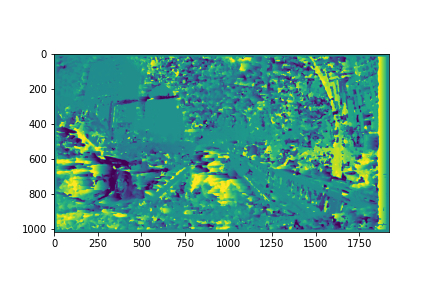

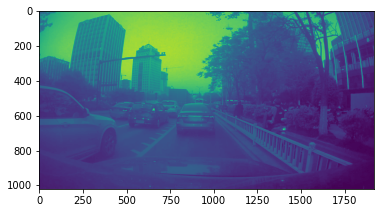

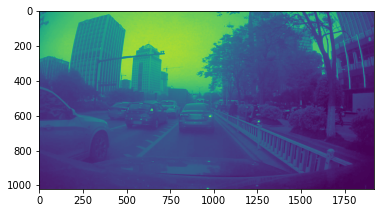

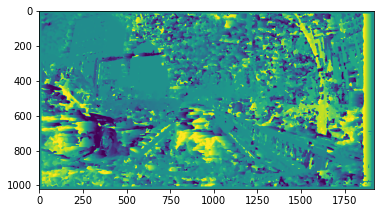

In [ ]:
#@title
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)
plt.figure()
plt.imshow(sad)
plt.show()

# Load from tar

In [ ]:
!pip install fs opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 KB 14.7 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/MyDrive/cs231a

/content/drive/MyDrive/cs231a


In [ ]:
#@title
#import tarfile
#tf = tarfile.open('train/train_cam01.tar')
!python3 -m tarfile -l train_lidar.tar | head #train/train_cam01.tar | grep "\.json" | head

data/ 
data/000092/ 
data/000092/lidar_roof/ 
data/000092/lidar_roof/1616442542799.bin 
data/000092/lidar_roof/1616443049299.bin 
data/000092/lidar_roof/1616442530300.bin 
data/000092/lidar_roof/1616442719799.bin 
data/000092/lidar_roof/1616442781800.bin 
data/000092/lidar_roof/1616442859300.bin 
data/000092/lidar_roof/1616442894300.bin 
Traceback (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.9/tarfile.py", line 2600, in <module>
    main()
  File "/usr/lib/python3.9/tarfile.py", line 2547, in main
    tf.list(verbose=args.verbose)
  File "/usr/lib/python3.9/tarfile.py", line 1947, in list
    print()
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
#@title
%%writefile Scene.py
import numpy as np
import pandas as pd
import os
import io
import json
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from fs import open_fs

class Scene():
    def __init__(self, data_dir, scene_id, lidar_dir=None, metadata_dir=None):
        self.scene_id = scene_id
        if lidar_dir is None: lidar_dir = data_dir
        if metadata_dir is None: metadata_dir = data_dir
        self.data_fs = open_fs(data_dir) if isinstance(data_dir, str) else data_dir
        self.lidar_fs = open_fs(lidar_dir) if isinstance(lidar_dir, str) else lidar_dir
        self.metadata_fs = open_fs(metadata_dir) if isinstance(metadata_dir, str) else metadata_dir
        self.metadata = json.load(self.metadata_fs.open(os.path.join('data', self.scene_id, f"{self.scene_id}.json")))

        self.weather = self.metadata["meta_info"]['weather']
        self.period = self.metadata["meta_info"]['period']
        self.image_size = self.metadata["meta_info"]['image_size']

        self.cams = list(self.metadata["calib"].keys())
        self.poses = np.array([self.metadata["frames"][i]['pose'] for i in range(len(self.metadata["frames"]))])
        self.frame_ids = np.array([int(self.metadata["frames"][i]['frame_id']) for i in range(len(self.metadata["frames"]))])


    def get_pose(self, frame_id):
        frame_idx = np.where(self.frame_ids == frame_id)[0][0]
        pose_vec = self.poses[frame_idx]
        pose = R.from_quat(pose_vec[:4]).as_matrix()
        pose = np.hstack((pose, np.zeros((3, 1))))
        pose[:3, 3] = pose_vec[4:]
        return pose


    def get_camera_pose(self, frame_id, cam_id):
        cam_pose = np.array(self.metadata["calib"][cam_id]["cam_to_velo"]) # 4x4
        return cam_pose


    def get_k(self, cam_id):
        return np.array(self.metadata["calib"][cam_id]["cam_intrinsic"]).reshape(3, 3)


    def get_camera_distortion(self, frame_id, cam_id):
        cam_distortion = np.array(self.metadata["calib"][cam_id]["distortion"]) # 1x7
        return cam_distortion

    
    def get_lidar_frame(self, frame_id):
        lidar_file = self.lidar_fs.openbin(os.path.join('data', self.scene_id, 'lidar_roof', f"{frame_id}.bin"))
        lidar_points = np.frombuffer(lidar_file.read(), dtype=np.float32).reshape(-1, 4)
        return lidar_points


    def get_cam_frame(self, frame_id, cam_id):
        cam_file = self.data_fs[cam_id].openbin(os.path.join('data', self.scene_id, cam_id, f"{frame_id}.jpg"))
        cam_image = np.array(Image.open(cam_file))
        return cam_image


    def plot_lidar_frame(self, frame_id):
        lidar_points = self.get_lidar_frame(frame_id)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(lidar_points[:, 0], lidar_points[:, 1], lidar_points[:, 2], c=lidar_points[:, 3], cmap='gray')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.show()




if __name__ == "__main__":
    scene = Scene(scene_id='000027')
    # scene.plot_lidar_frame(frame_id=scene.frame_ids[0])
    scene.get_cam_frame(frame_id=scene.frame_ids[0], cam_id=scene.cams[0])

Overwriting Scene.py


In [ ]:
import importlib
import Scene
importlib.reload(Scene)
from Scene import Scene
from fs.tarfs import TarFS
from fs.multifs import MultiFS
import cv2
#with TarFS('train/train_cam01.tar') as fs, TarFS('train_lidar.tar') as lfs, TarFS('train_infos.tar') as mfs:
# fs = MultiFS()
# for i in range(1, 10):
#   if i not in (2, 4):
#     fs.add_fs(f'cam0{i}', TarFS(f'train/train_cam0{i}.tar'))
fs = {f'cam0{i}': TarFS(f'train/train_cam0{i}.tar') for i in range(1, 10) if i not in (2, 4)} # TarFS(f'train/train_cam01.tar')
lfs = TarFS('train_lidar.tar')
mfs = TarFS('train_infos.tar')
scene = Scene(fs, scene_id='000092', lidar_dir=lfs, metadata_dir=mfs) #!python -m tarfile -l train/train_cam01.tar | head

In [ ]:
import importlib
import Scene
importlib.reload(Scene)
from Scene import Scene
from fs.tarfs import TarFS
import cv2
fs = {f'cam0{i}': TarFS(f'val/val_cam0{i}.tar') for i in range(1, 10) if i not in (2, 4)} # TarFS(f'train/train_cam01.tar')
lfs = TarFS('val_lidar.tar')
mfs = TarFS('val_infos.tar')
scene = Scene(fs, scene_id='000027', lidar_dir=lfs, metadata_dir=mfs) #!python -m tarfile -l train/train_cam01.tar | head

In [ ]:
#@title
objectPoints = scene.get_lidar_frame(frame_id=scene.frame_ids[0])
cameraMatrix = scene.get_k(cam_id=scene.cams[0])
cam_pose = scene.get_camera_pose(frame_id=scene.frame_ids[0], cam_id=scene.cams[0])

[_, rotMatrix, tvec, *_] = cv2.decomposeProjectionMatrix(cam_pose[:3, :])
rvec, _ = cv2.Rodrigues(rotMatrix.T)
# rvec, _ = cv2.Rodrigues(cam_pose[:3, :3])
# tvec = cam_pose[:3, 3]

distCoeffs = scene.get_camera_distortion(frame_id=scene.frame_ids[0], cam_id=scene.cams[0])
print(objectPoints[:, :3].shape, rvec[:, 0].shape, tvec[:3, 0].shape, cameraMatrix.shape, distCoeffs.shape)
imagePoints, _ = cv2.projectPoints(objectPoints[:, np.newaxis, :3], rvec[:, 0], -tvec[:3, 0], cameraMatrix, distCoeffs)

(67244, 3) (3,) (3,) (3, 3) (5,)


In [ ]:
#@title
imagePoints[:, 0, :]

array([[ 845.832  ,  541.54877],
       [ 987.18604,  533.2199 ],
       [ 845.99536,  524.3526 ],
       ...,
       [ 901.58875,  262.1757 ],
       [ 900.4498 ,  241.86638],
       [ 715.4598 , -341.19217]], dtype=float32)

In [ ]:
#@title
import numpy as np
image_points = (cameraMatrix @ cam_pose[:3, :] @ objectPoints.T).T
image_points /= image_points[:, 2, np.newaxis]
image_points = image_points[:, :2]
# image_points = imagePoints[:, 0, :]
mask = (0 <= image_points[:, 0]) & (image_points[:, 0] < 1080) & (0 <= image_points[:, 1]) & (image_points[:, 1] < 1920)
image_points = image_points[mask]
depth_points = objectPoints[:, 2][mask]
grid_x, grid_y = np.mgrid[0:1080, 0:1920]
import scipy.interpolate
data = scipy.interpolate.griddata(image_points, depth_points, (grid_x, grid_y))

[[867.446557   568.8228608    1.        ]
 [998.58779748 538.1446916    1.        ]
 [869.24538366 556.14612669   1.        ]
 ...
 [928.64946533 315.43916937   1.        ]
 [925.60066544 288.83886005   1.        ]
 [925.23705026 197.34921551   1.        ]] [[ 845.832    541.54877]
 [ 987.18604  533.2199 ]
 [ 845.99536  524.3526 ]
 ...
 [ 901.58875  262.1757 ]
 [ 900.4498   241.86638]
 [ 715.4598  -341.19217]]


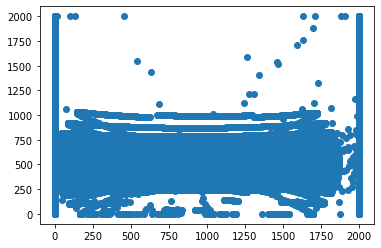

In [ ]:
#@title
imagePoints2= (np.clip(imagePoints, 0, 2000))
plt.scatter(imagePoints2[:, 0, 0], imagePoints2[:, 0, 1])

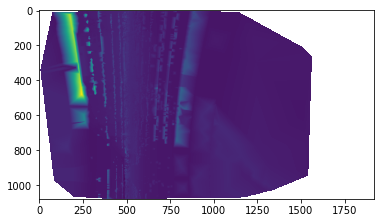

In [ ]:
#@title
import matplotlib.pyplot as plt
plt.imshow(data)

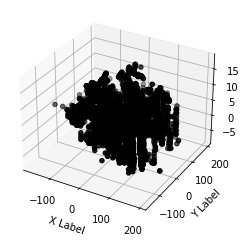

In [ ]:
scene.plot_lidar_frame(frame_id=scene.frame_ids[0])

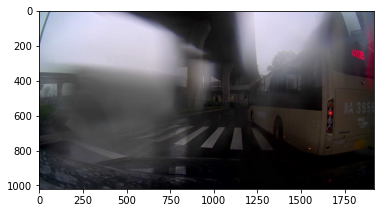

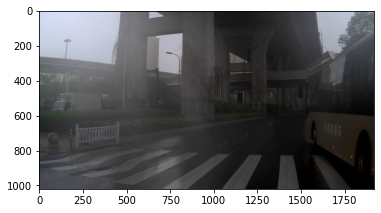

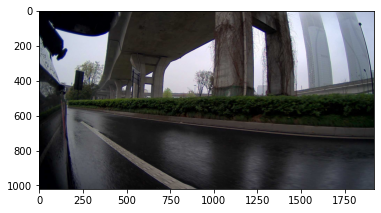

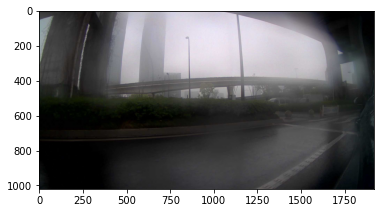

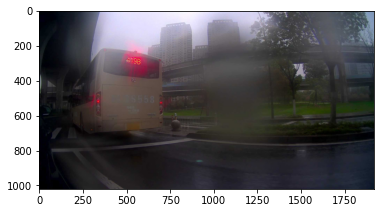

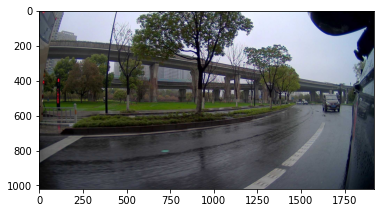

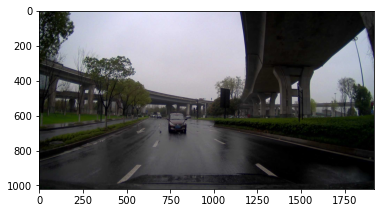

In [ ]:
import matplotlib.pyplot as plt
for i in scene.cams:
  camframe = scene.get_cam_frame(frame_id=scene.frame_ids[1], cam_id=i)
  plt.figure()
  plt.imshow(camframe)

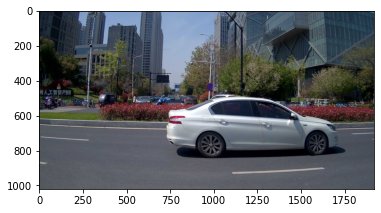

In [ ]:
import matplotlib.pyplot as plt
camframe = scene.get_cam_frame(frame_id=scene.frame_ids[1], cam_id=scene.cams[1])
plt.imshow(camframe)

# M4Depth

In [ ]:
!pip install 'tensorflow==2.7.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.1/496.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Foun

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/cs231a

/content/drive/.shortcut-targets-by-id/1kdgehsT_sD4A96j16iPx7NWiivQZ24w7/cs231a


In [ ]:
!ls /content/drive/MyDrive/cs231a/scenes/

000027	000201	__MACOSX  __pycache__  scenes


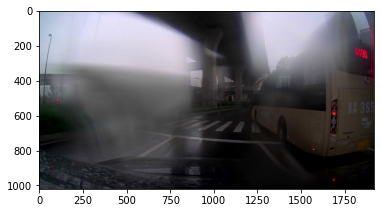

In [ ]:
from Scene import Scene
scene = Scene('/content/drive/MyDrive/cs231a', scene_id='000027')
import matplotlib.pyplot as plt
plt.imshow(scene.get_cam_frame(frame_id=scene.frame_ids[0], cam_id=scene.cams[0]))

In [ ]:
%cd /content
!git clone https://github.com/michael-fonder/M4Depth
%cd M4Depth
!unzip '*.zip'
%cd cuda_backproject
!bash make.sh
%cd ..
#!python main.py --help

/content
Cloning into 'M4Depth'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 205 (delta 41), reused 88 (delta 25), pack-reused 89
Receiving objects: 100% (205/205), 150.82 MiB | 15.53 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (100/100), done.
/content/M4Depth
Archive:  data.zip
   creating: data/
   creating: data/kitti-raw/
   creating: data/kitti-raw-filtered/
   creating: data/kitti-raw-filtered/test_data/
  inflating: data/kitti-raw-filtered/test_data/2011_09_26_drive_0002_sync.csv  
  inflating: data/kitti-raw-filtered/test_data/2011_09_26_drive_0009_sync.csv  
  inflating: data/kitti-raw-filtered/test_data/2011_09_26_drive_0013_sync.csv  
  inflating: data/kitti-raw-filtered/test_data/2011_09_26_drive_0020_sync.csv  
  inflating: data/kitti-raw-filtered/test_data/2011_09_26_drive_0023_sync.csv  
  inflating: data/kitti-raw-filtered/test_data/2

In [ ]:
!mkdir -p data/once

In [ ]:
!ln -s /content/drive/MyDrive/cs231a/scenes data/once/scenes

In [ ]:
!rm -rf data/once/scenes
!mkdir data/once/scenes

In [ ]:
!ls /content/drive/MyDrive/cs231a/val/val_cam03.tar

/content/drive/MyDrive/cs231a/val/val_cam03.tar


In [ ]:
!tar -xf /content/drive/MyDrive/cs231a/val_infos.tar --wildcards "data/000027/000027.json" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val_lidar.tar --wildcards "data/000027/lidar_roof/*.bin" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam01.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam03.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam05.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam06.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam07.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam08.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf /content/drive/MyDrive/cs231a/val/val_cam09.tar --wildcards "data/000027/*/*.jpg" -C scene2

In [ ]:
!mv data/000027 data/once/scenes

In [ ]:
!ls data/once/scenes

000027


In [ ]:
len(scene.frame_ids)

2294

In [ ]:
#%%writefile once_to_csv.py
import numpy as np
import os
for cam_idx, cam_id in enumerate(scene.cams):
  with open(f'data/once/000027_sync_{cam_id}.csv', 'w') as file: # 201
    file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % ("id", "camera_l", "qx", "qy", "qz", "qw", "tx", "ty", "tz", "fx", "fy", "cx", "cy"))
    for frame_idx, frame_id in enumerate(scene.frame_ids):
      # if frame_idx > 10: break
      if frame_idx % 200 != 0: continue
      # frame = scene.get_cam_frame(frame_id=frame_id, cam_id=cam_id)
      # frame_idx = np.where(scene.frame_ids == frame_id)[0][0]
      cam_file = os.path.join(scene.data_dir, cam_id, f"{frame_id}.jpg").replace('/content/drive/MyDrive/cs231a/', '')
      if not os.path.exists('data/once/' + cam_file):
        print(cam_file)
        continue
      pose_vec = scene.poses[frame_idx]
      k = scene.get_k(cam_id)
      fx = k[0, 0]
      fy = k[1, 1]
      cx = k[2, 0]
      cy = k[2, 1]
      file.write("%i\t%s\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\t%f\n" % (cam_idx, cam_file, *pose_vec, fx, fy, cx, cy))


In [ ]:
#@title
%%writefile dataloaders/once.py
import tensorflow as tf
from .generic import *
import numpy as np

class DataLoaderOnce(DataLoaderGeneric):
    """Dataloader for the ONCE
    """
    def __init__(self):
        super(DataLoaderOnce, self).__init__('once')

        self.in_size = [370, 1220]
        self.depth_type = "velodyne"

    def _set_output_size(self, out_size=[256, 768]):
        self.out_size = out_size
        crop = np.array([0.40810811 * out_size[0], 0.99189189 * out_size[0],
                         0.03594771 * out_size[1], 0.96405229 * out_size[1]]).astype(np.int32)
        crop_mask = np.zeros(self.out_size + [1])
        crop_mask[crop[0]:crop[1], crop[2]:crop[3], :] = 1
        self.eval_crop_mask = tf.convert_to_tensor(crop_mask, dtype=tf.float32)

    @tf.function
    def _decode_samples(self, data_sample):
        file = tf.io.read_file(tf.strings.join([self.db_path, data_sample['camera_l']], separator='/'))
        image = tf.io.decode_jpeg(file)
        rgb_image = tf.cast(image, dtype=tf.float32)/255.

        camera_data = {
            "id": data_sample['id'],
            "f": tf.convert_to_tensor([data_sample['fx']/self.in_size[1]*self.out_size[1], data_sample['fy']/self.in_size[0]*self.out_size[0]], dtype=tf.float32),
            "c": tf.convert_to_tensor([data_sample['cx']/self.in_size[1]*self.out_size[1], data_sample['cy']/self.in_size[0]*self.out_size[0]], dtype=tf.float32),
        }
        out_data = {}
        out_data["camera"] = camera_data.copy()
        out_data['RGB_im'] = tf.reshape(tf.image.resize(rgb_image, self.out_size), self.out_size+[3])
        out_data['depth'] = tf.zeros(134235)
        out_data['rot'] = tf.cast(tf.stack([data_sample['qw'],data_sample['qx'],data_sample['qy'],data_sample['qz']], 0), dtype=tf.float32)
        out_data['trans'] = tf.cast(tf.stack([data_sample['tx'],data_sample['ty'],data_sample['tz']], 0), dtype=tf.float32)
        out_data['new_traj'] = tf.math.equal(data_sample['id'], 0)

        return out_data

    def _perform_augmentation(self):
        #self._augmentation_step_flip()
        self._augmentation_step_color(invert_color=False)


Writing dataloaders/once.py


In [ ]:
#!bash  scripts/0b-get_kitti.sh datasets/Kitti

Streaming output truncated to the last 5000 lines.
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000174.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000102.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000377.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000015.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000373.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000242.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000077.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000398.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000026.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000083.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_sync/image_00/data/0000000151.png  
 extracting: 2011_09_26/2011_09_26_drive_0029_s

In [ ]:
!bash  scripts/2-evaluate.sh once

Could not import cuda Backproject Module, using python implementation
The current working directory is : /content/M4Depth
Evaluating on once
Evaluating on subsequences of length 4
/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
Checkpoint save directory: pretrained_weights/kitti/best
Latest checkpoint found: pretrained_weights/kitti/best/cp-0077.ckpt
Restoring weights from pretrained_weights/kitti/best/cp-0077.ckpt
Traceback (most recent call last):
  File "/content/M4Depth/main.py", line 133, in <module>
    metrics = model.evaluate(data, callbacks=[model_checkpoint_cbk])
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with

In [ ]:
!git diff

diff --git a/dataloaders/__init__.py b/dataloaders/__init__.py
index 334ce22..7ce3742 100644
--- a/dataloaders/__init__.py
+++ b/dataloaders/__init__.py
@@ -1,12 +1,14 @@
 from .midair import DataLoaderMidAir as MidAir
 from .kitti import DataLoaderKittiRaw as KittiRaw
 from .tartanair import DataLoaderTartanAir as TartanAir
+from .once import DataLoaderOnce as Once
 from .generic import DataloaderParameters
 
 def get_loader(name : str):
     available = {
         "midair"        : MidAir(),
         "kitti-raw"     : KittiRaw(),
+        "once"     : Once(),
         "tartanair"   : TartanAir()
     }
     try:
diff --git a/dataloaders/generic.py b/dataloaders/generic.py
index ac61404..f2525af 100644
--- a/dataloaders/generic.py
+++ b/dataloaders/generic.py
@@ -60,7 +60,7 @@ class DataLoaderGeneric():
 
         self.settings = settings
         self.records_path = settings.records_path
-        self.db_path = settings.db_path_config[self.db_name]
+        self.db_path = 'data/once'

In [ ]:
#@title
%%writefile a.patch
diff --git a/dataloaders/__init__.py b/dataloaders/__init__.py
index 334ce22..7ce3742 100644
--- a/dataloaders/__init__.py
+++ b/dataloaders/__init__.py
@@ -1,12 +1,14 @@
 from .midair import DataLoaderMidAir as MidAir
 from .kitti import DataLoaderKittiRaw as KittiRaw
 from .tartanair import DataLoaderTartanAir as TartanAir
+from .once import DataLoaderOnce as Once
 from .generic import DataloaderParameters
 
 def get_loader(name : str):
     available = {
         "midair"        : MidAir(),
         "kitti-raw"     : KittiRaw(),
+        "once"     : Once(),
         "tartanair"   : TartanAir()
     }
     try:
diff --git a/dataloaders/generic.py b/dataloaders/generic.py
index ac61404..f2525af 100644
--- a/dataloaders/generic.py
+++ b/dataloaders/generic.py
@@ -60,7 +60,7 @@ class DataLoaderGeneric():
 
         self.settings = settings
         self.records_path = settings.records_path
-        self.db_path = settings.db_path_config[self.db_name]
+        self.db_path = 'data/once'#settings.db_path_config[self.db_name]
         self.db_seq_len = self.settings.db_seq_len
         self.seq_len = self.settings.seq_len
         self.batch_size = batch_size
@@ -127,6 +127,8 @@ class DataLoaderGeneric():
         trajectories = self._get_trajectories()
         dataset = None
         for traj in trajectories:
+            if "{'id': TensorSpec(shape=(), dtype=tf.string, name=None)" in repr(traj._type_spec):
+              continue # ['id'].dtype == tf.string
             traj = traj.map(self._decode_samples, num_parallel_calls=tf.data.AUTOTUNE)
             if self.db_seq_len is not None:
                 traj = traj.batch(self.db_seq_len, drop_remainder=True)
@@ -168,7 +170,9 @@ class DataLoaderGeneric():
         pos = data_sample["trans"]
         l = rot.get_shape().as_list()[-1]
 
+
         camera_data = {
+            "id": data_sample["camera"]['id'][0],
             "f": data_sample["camera"]['f'][0, :],
             "c": data_sample["camera"]['c'][0, :]
         }
diff --git a/m4depth_network.py b/m4depth_network.py
index 185e976..5881ef4 100644
--- a/m4depth_network.py
+++ b/m4depth_network.py
@@ -350,7 +350,20 @@ class M4Depth(ks.models.Model):
 
     @tf.function
     def call(self, data, training=False):
-        traj_samples = data[0]
+        traj_samples0 = data[0]
+        # rebatch these correctly because TF sucks
+        print(traj_samples0.keys())
+        traj_samples = [
+          {
+            'camera': traj_samples0['camera'],
+            'depth': traj_samples0['depth'][:, i],
+            'RGB_im': traj_samples0['RGB_im'][:, i],
+            'rot': traj_samples0['rot'][:, i],
+            'trans': traj_samples0['trans'][:, i],
+            'new_traj': traj_samples0['new_traj'][:, i],
+          }
+          for i in range(traj_samples0['depth'].shape[1])
+        ]
         camera = data[1]
         with tf.name_scope("M4Depth"):
             self.step_counter.assign_add(1)
@@ -476,7 +489,7 @@ class M4Depth(ks.models.Model):
     @tf.function
     def predict_step(self, data):
         # expects one sequence element at a time (batch dim is required and is free to be set)"
-        preds = self([[data], data["camera"]], training=False)
+        preds = self([data, data["camera"]], training=False)
 
         with tf.name_scope("metrics"):
             est = preds
diff --git a/m4depth_options.py b/m4depth_options.py
index bba422a..dac916f 100644
--- a/m4depth_options.py
+++ b/m4depth_options.py
@@ -10,7 +10,7 @@ class M4DepthOptions:
         # Global Options
         args.add_argument('--dataset',
                           default="",
-                          choices=['midair', 'tartanair', 'kitti-raw'],
+                          choices=['midair', 'tartanair', 'kitti-raw', 'once'],
                           help="""Dataset to use (midair, tartanair or kitti-raw)""")
         args.add_argument('--ckpt_dir',
                           default="ckpt",
diff --git a/main.py b/main.py
index ec95f6d..7ad662a 100644
--- a/main.py
+++ b/main.py
@@ -33,7 +33,7 @@ from callbacks import *
 from m4depth_network import *
 from metrics import *
 import time
-
+tf.config.run_functions_eagerly(True)
 if __name__ == '__main__':
 
     cmdline = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
@@ -154,21 +154,30 @@ if __name__ == '__main__':
         model = M4Depth(nbre_levels=nbre_levels, ablation_settings=model_opts.ablation_settings)
         model.compile()
         model_checkpoint_cbk = CustomCheckpointCallback(os.path.join(ckpt_dir, "best"), resume_training=True)
-        first_sample = data.take(1)
-        model.predict(first_sample, callbacks=[model_checkpoint_cbk])
+        # first_sample = data.take(1)
+        # print(first_sample)
+        # model.predict(first_sample, callbacks=[model_checkpoint_cbk])
 
         is_first_run = True
 
+        from collections import defaultdict
+        samples = defaultdict(list) #[]
+
         # Do what you want with the outputs
         for i, sample in enumerate(data):
-            if not is_first_run and sample["new_traj"]:
+            if not is_first_run and tf.math.reduce_any(sample["new_traj"]):
                 print("End of trajectory")
 
             is_first_run = False
 
-            est = model([[sample], sample["camera"]]) # Run network to get estimates
-            d_est = est["depth"][0, :, :, :]        # Estimate : [h,w,1] matrix with depth in meter
-            d_gt = sample['depth'][0, :, :, :]      # Ground truth : [h,w,1] matrix with depth in meter
-            i_rgb = sample['RGB_im'][0, :, :, :]    # RGB image : [h,w,3] matrix with rgb channels ranging between 0 and 1
+            est = model([sample, sample["camera"]]) # Run network to get estimates
+            d_est = est["depth"][0, :, :]        # Estimate : [h,w,1] matrix with depth in meter
+            d_gt = sample['depth'][0, :, :]      # Ground truth : [h,w,1] matrix with depth in meter
+            i_rgb = sample['RGB_im'][0, :, :]    # RGB image : [h,w,3] matrix with rgb channels ranging between 0 and 1
 
+            samples[int(sample["camera"]['id'][0])].append(est["depth"][0, :, :, 0].numpy())
 
+        import pickle
+        import numpy as np
+        with open('prediction.pkl', 'wb') as f:
+          pickle.dump(np.stack(list(samples.values())), f)
\ No newline at end of file
diff --git a/scripts/2-evaluate.sh b/scripts/2-evaluate.sh
index d38aeaa..8666b33 100644
--- a/scripts/2-evaluate.sh
+++ b/scripts/2-evaluate.sh
@@ -28,6 +28,16 @@ case "$dataset" in
         dataset="kitti-raw"
         ;;
 
+    "once")
+        if [ -z "$2" ]
+        then
+            savepath="pretrained_weights/kitti"
+        fi
+        db_seq_len="--db_seq_len=4"
+        data="data/once"
+        dataset="once"
+        ;;
+
     "tartanair-gascola")
         if [ -z "$2" ]
         then


Writing a.patch


In [ ]:
!git apply --reject --whitespace=fix a.patch

Checking patch dataloaders/__init__.py...
Checking patch dataloaders/generic.py...
Checking patch m4depth_network.py...
Checking patch m4depth_options.py...
Checking patch main.py...
Checking patch scripts/2-evaluate.sh...
Applied patch dataloaders/__init__.py cleanly.
Applied patch dataloaders/generic.py cleanly.
Applied patch m4depth_network.py cleanly.
Applied patch m4depth_options.py cleanly.
Applied patch main.py cleanly.
Applied patch scripts/2-evaluate.sh cleanly.


In [ ]:
!python main.py --mode=predict --dataset=once --db_seq_len=4 --arch_depth=6 --ckpt_dir=pretrained_weights/kitti --records=data/once

Could not import cuda Backproject Module, using python implementation
The current working directory is : /content/M4Depth
Evaluating on subsequences of length 4
/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
Checkpoint save directory: pretrained_weights/kitti/best
Latest checkpoint found: pretrained_weights/kitti/best/cp-0077.ckpt
dict_keys(['camera', 'depth', 'RGB_im', 'rot', 'trans', 'new_traj'])
Seq sample 0
Seq sample 1
Seq sample 2
Seq sample 3
End of trajectory
dict_keys(['camera', 'depth', 'RGB_im', 'rot', 'trans', 'new_traj'])
Seq sample 0
Seq sample 1
Seq sample 2
Seq sample 3
End of trajectory
dict_keys(['camera', 'depth', 'RGB_im', 'rot', 'trans', 'new_traj'])
Seq sample 0
Seq samp

In [ ]:
import os, glob
for f in glob.glob('data/once/scenes/000027-trash/**', recursive=True):
  try:
    os.rename(f, f.replace('-trash',''))
    print(f)
  except:
    pass


data/once/scenes/000027-trash/


In [ ]:
import pickle
with open('prediction.pkl', 'rb') as f:
  samples = pickle.load(f)

In [ ]:
samples = np.stack(list(samples.values()))

In [ ]:
samples.shape

(7, 2, 256, 768)

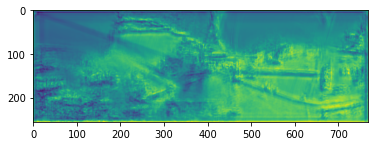

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(samples[0][0])

In [ ]:
!cp prediction.pkl /content/drive/MyDrive/cs231a/